# 5. Analysis of Exchange Pattern

In [1]:
import pandas as pd
import pickle
import numpy as np
# Plot the relationship between genres
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from func import get_relationship, relationship_with_name, plot_relationship

## 1. Load the Reddit Data
paris_dense is the confirmed transaction data with time from Rappaz et. al (2017).

In [2]:
pair_time = pd.read_csv('./data/pairs_dense.csv',names=['user1','game1','user2','game2','time'])
pair_time['time'] = pd.to_datetime(pair_time['time'],unit='s')
pair_time.loc[pair_time['time']<'1970-01-01']

,user1,game1,user2,game2,time
588,13866,590,3357,461,1969-12-31 23:59:59
730,9752,1785,604,1183,1969-12-31 23:59:59


We can see that the exchange data starts from 2013-10-01 to 2015-09-22.

In [3]:
pair_time[pair_time['time']>='2000-01-01'].time.describe(datetime_is_numeric=True)

count                             2096
mean     2014-04-28 05:21:50.124045824
min                2013-10-01 19:51:32
25%                2013-11-05 03:47:58
50%                2014-01-27 19:25:24
75%                2014-09-14 02:22:07
max                2015-09-22 22:06:52
Name: time, dtype: object

In [4]:
# Load the gameswap transaction data with col names ['user1','game1','user2','game2']
pair = pd.read_csv('./data/pairs.csv', names=['user1','game1','user2','game2'])
# Load have and wish data
have = pd.read_csv('./data/have.csv', names=['user','game'])
wish = pd.read_csv('./data/wish_dense.csv', names=['user','game'])
# Load the games data we get from IGDB
games = pd.read_csv('./data/games_tbp.csv', index_col=0)
# Add a column of index with name 'game_id', second column
games.insert(1, 'game_id', range(0, len(games)))
games_genres = games[['game_id', 'genres']]

In [5]:
# Outer join have and wish on user
have_wish = have.merge(wish, on='user', how='outer', suffixes=['1','2']).astype('Int64')
print(have_wish.shape)

(332258, 3)


In [6]:
print("#Rows that people don't list what they have:", have_wish.loc[have_wish['game1'].isnull()].shape[0])
print("#Rows that people don't list what they wish:", have_wish.loc[have_wish['game2'].isnull()].shape[0])

#Rows that people don't list what they have: 4039
#Rows that people don't list what they wish: 4070


In [7]:
have_wish_cleaned = have_wish.dropna()
have_wish_relationship = get_relationship(have_wish_cleaned, games_genres, have_wish=True)

confirmed_relationship = get_relationship(pair, games_genres)

## 2. Plot the relationship
The detailed information about the games is obtained using IGDB.


In [9]:
with open('data/genres_igdb.pkl','rb') as f:
    genres_names = pickle.load(f)[['id','name']]
genres_names.T

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
id,4,5,7,8,9,10,11,12,13,14,...,26,25,30,31,33,34,32,35,36,2
name,Fighting,Shooter,Music,Platform,Puzzle,Racing,Real Time Strategy (RTS),Role-playing (RPG),Simulator,Sport,...,Quiz/Trivia,Hack and slash/Beat 'em up,Pinball,Adventure,Arcade,Visual Novel,Indie,Card & Board Game,MOBA,Point-and-click


/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


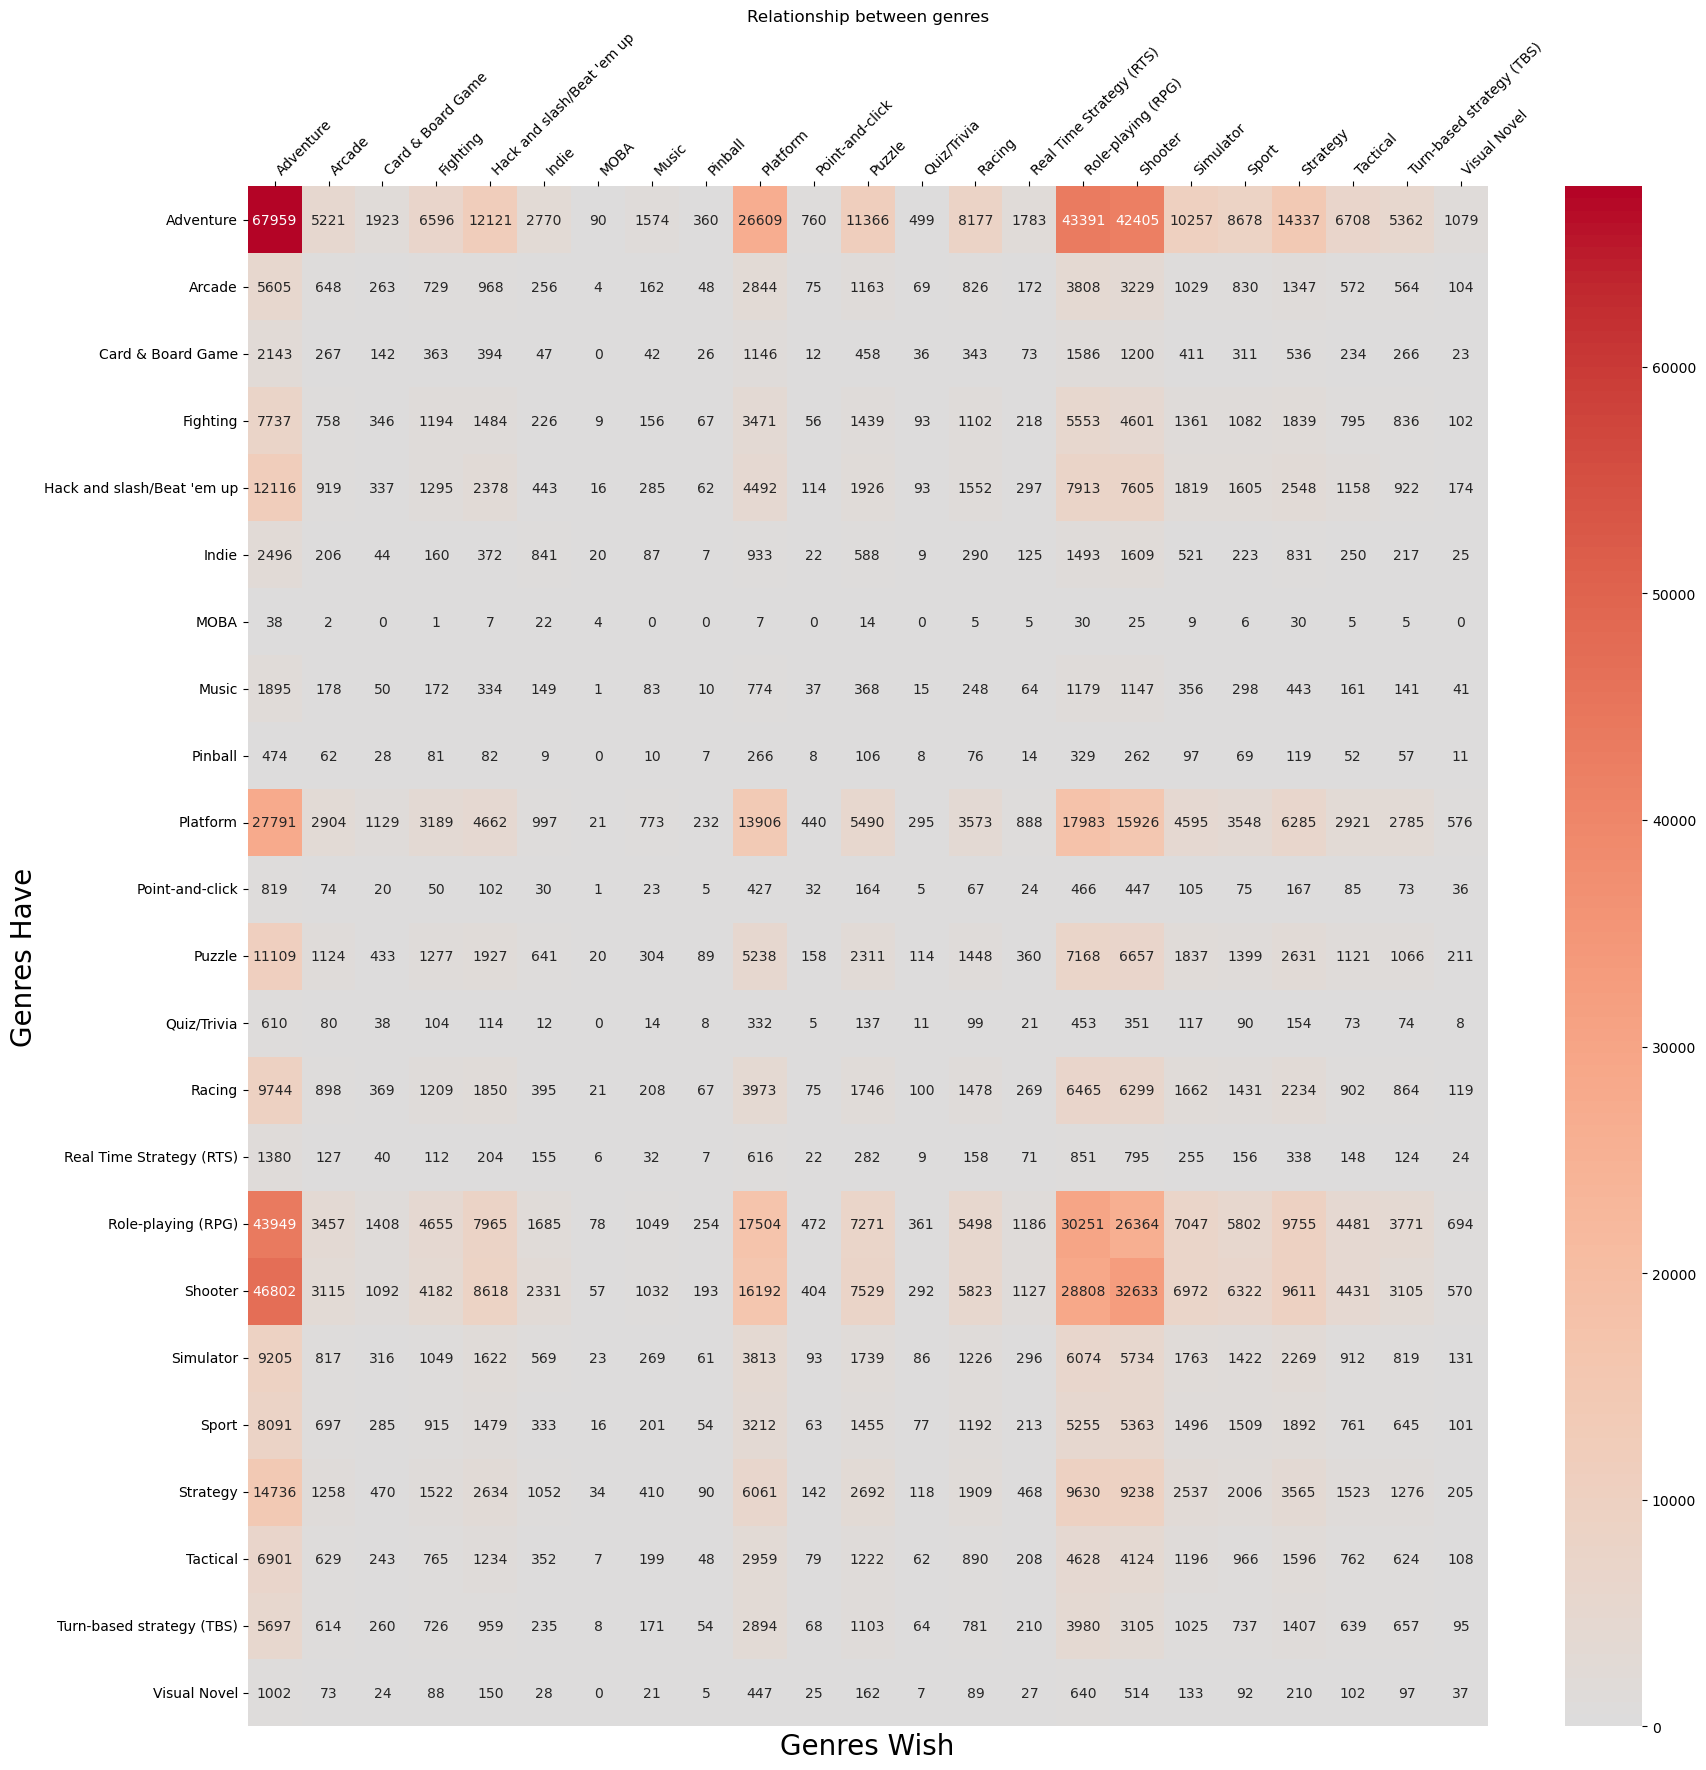

In [10]:
plot_relationship(have_wish_relationship, 'have_wish', genres_names=genres_names, have_wish=True)

In [11]:
relationship_confirmed = relationship_with_name(confirmed_relationship, genres_names)
relationship_have_wish = relationship_with_name(have_wish_relationship, genres_names, have_wish=True)

genres_confirmed = relationship_confirmed.columns
genres_have_wish = relationship_have_wish.columns

# Expand the relationship_confirmed and relationship_have_wish to the same size
relationship_confirmed = relationship_confirmed.reindex(index=relationship_have_wish.index, columns=relationship_have_wish.columns, fill_value=0)

# Normalize the relationship_confirmed and relationship_have_wish, they are symmetric
relationship_confirmed_norm = relationship_confirmed.apply(lambda x: x/x.sum() if x.sum()!=0 else 0, axis=1)
# for i in range(relationship_confirmed_norm.shape[0]):
#     relationship_confirmed_norm.iloc[i,:] = relationship_confirmed_norm.iloc[:,i] 
relationship_confirmed_norm.fillna(0, inplace=True)

relationship_have_wish_norm = relationship_have_wish.apply(lambda x: x/x.sum() if x.sum()!=0 else 0, axis=1)
# for i in range(relationship_have_wish_norm.shape[0]):
#     relationship_have_wish_norm.iloc[i,:] = relationship_have_wish_norm.iloc[:,i]
relationship_have_wish_norm.fillna(0, inplace=True)

# Calculate the difference between relationship_confirmed and relationship_have_wish
relationship_diff = relationship_have_wish_norm - relationship_confirmed_norm

# Transform the dataframe to be better for plotting.
relationship_diff_plot = relationship_diff.copy()
relationship_diff_plot = 100 * relationship_diff_plot
relationship_diff_plot = relationship_diff_plot.round(2)

/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')
/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


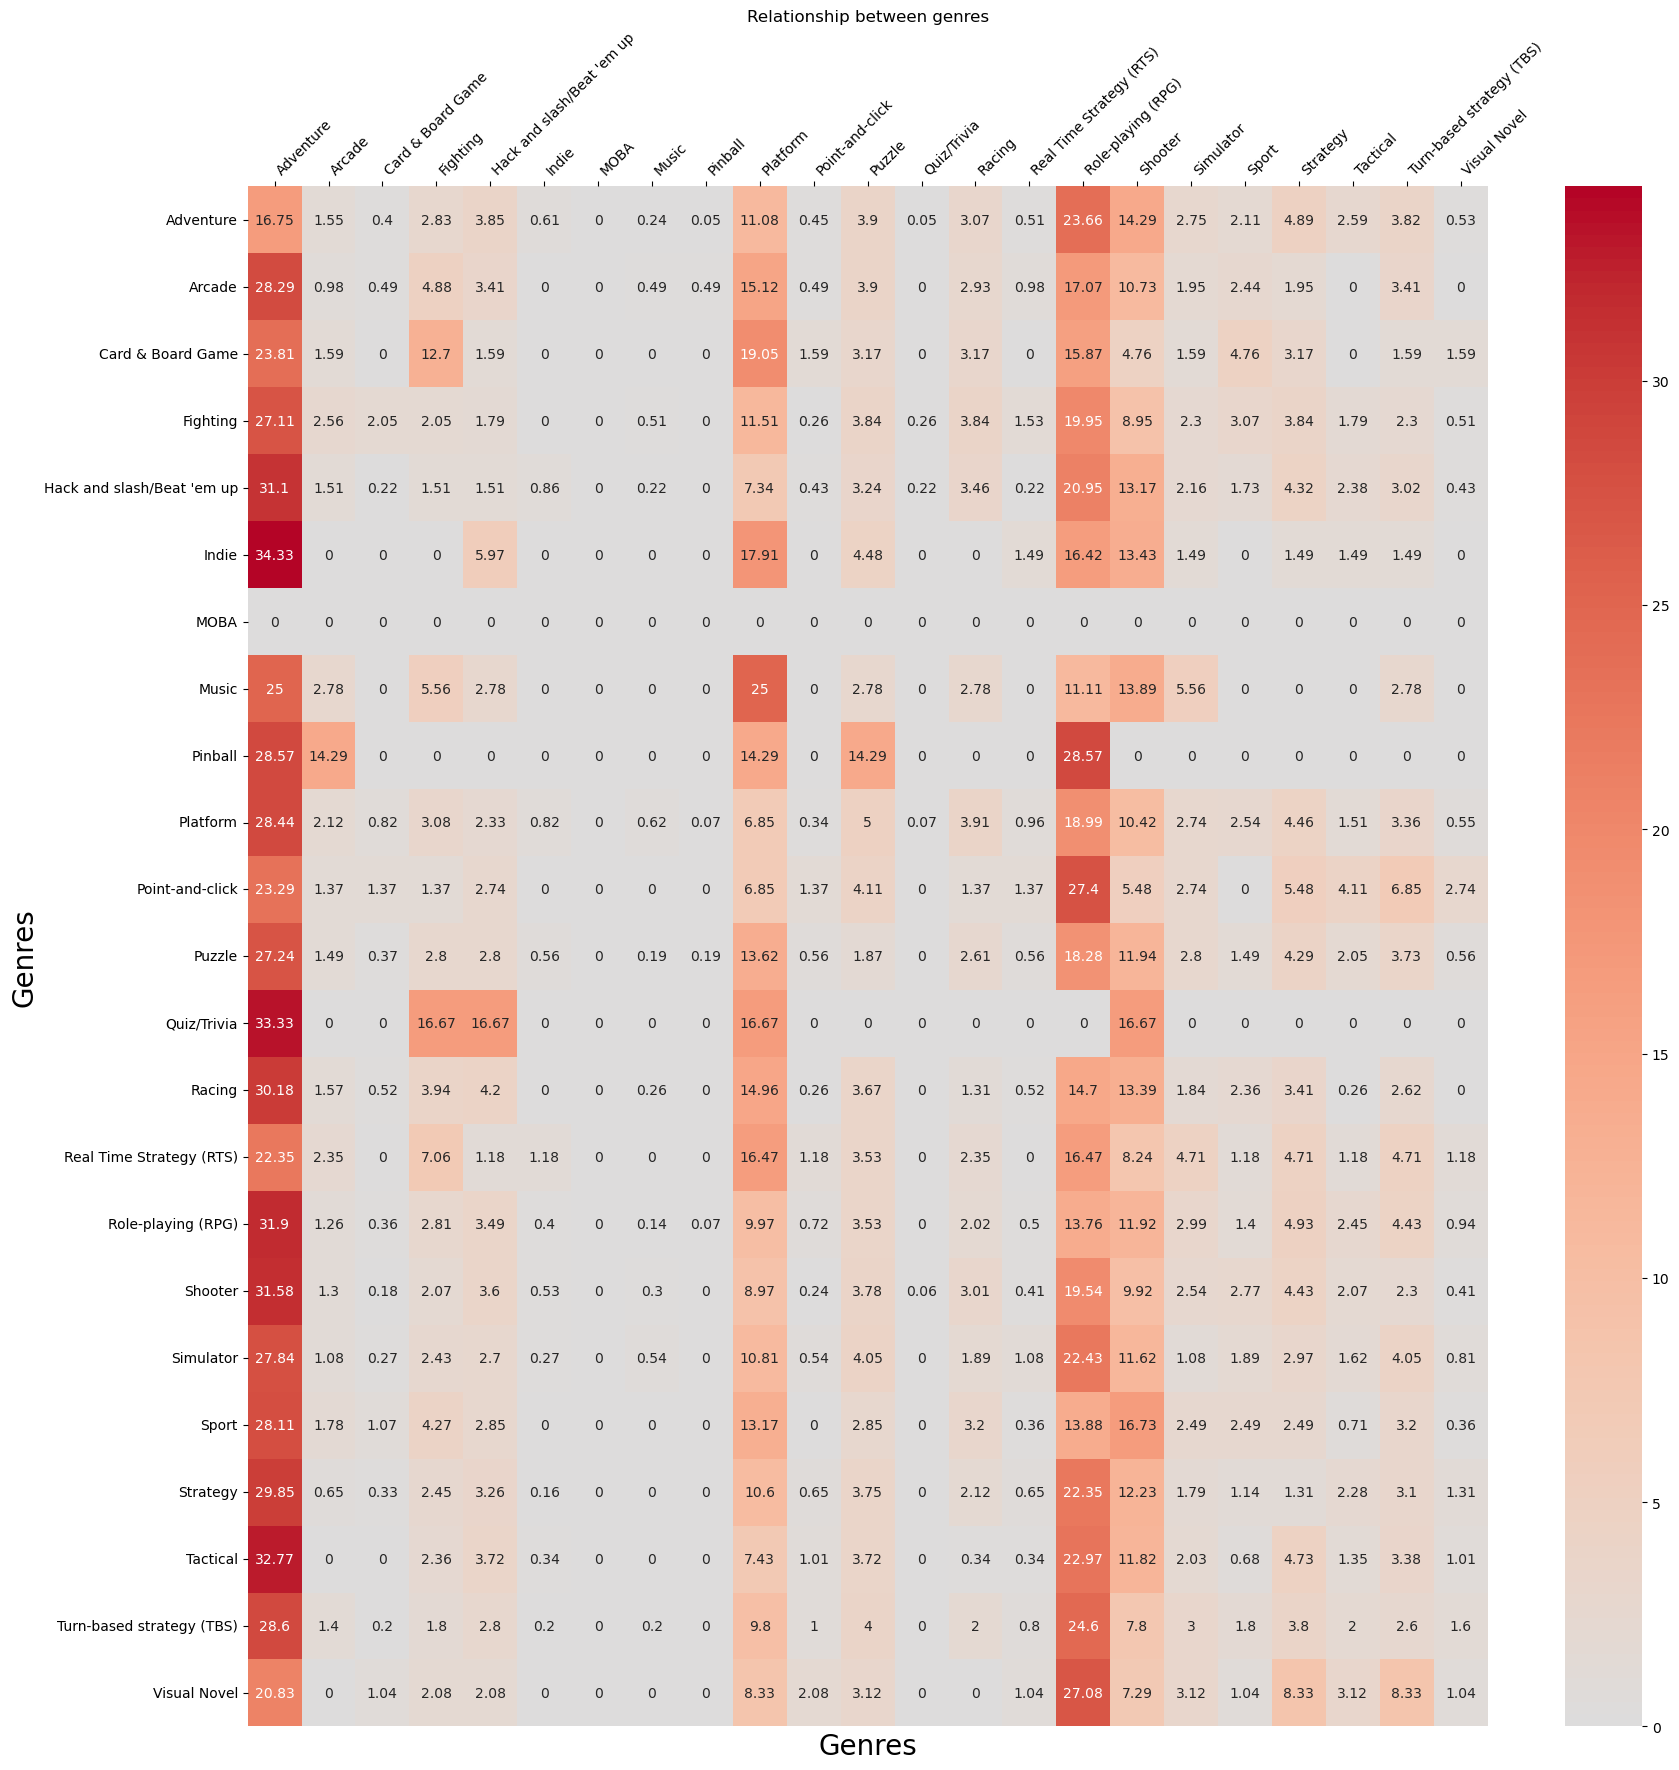

In [12]:
plot_relationship((100*relationship_confirmed_norm).round(2), 'confirmed_norm', genres_names=genres_names, have_wish=False,processed=True)

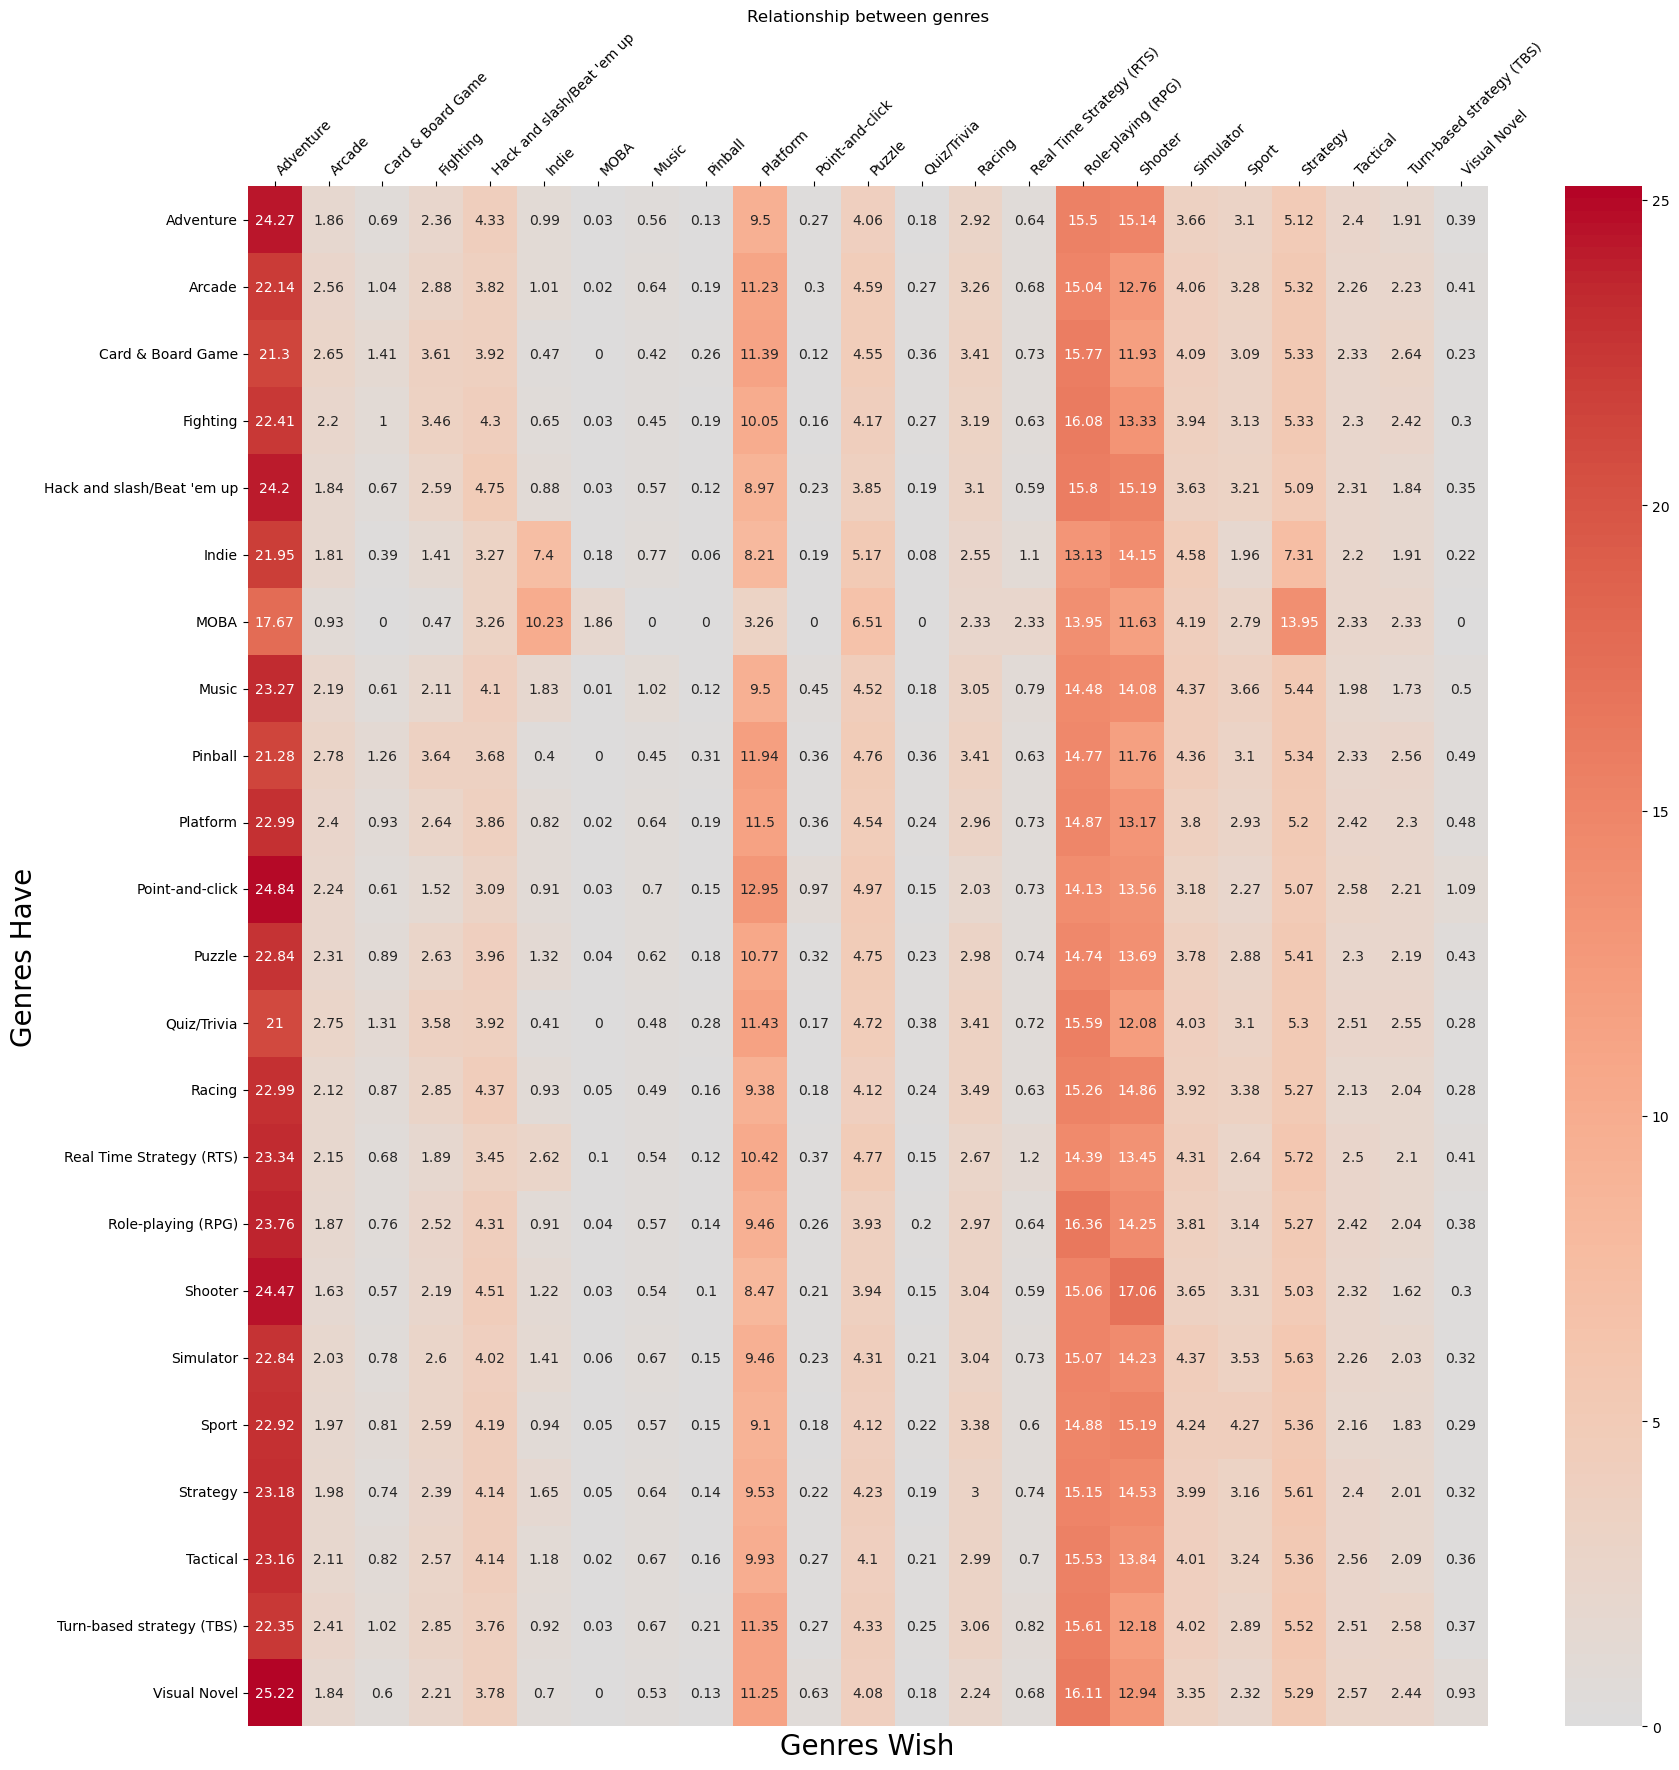

In [13]:
plot_relationship((100*relationship_have_wish_norm).round(2), 'have_wish_norm', genres_names=genres_names, have_wish=True,processed=True)

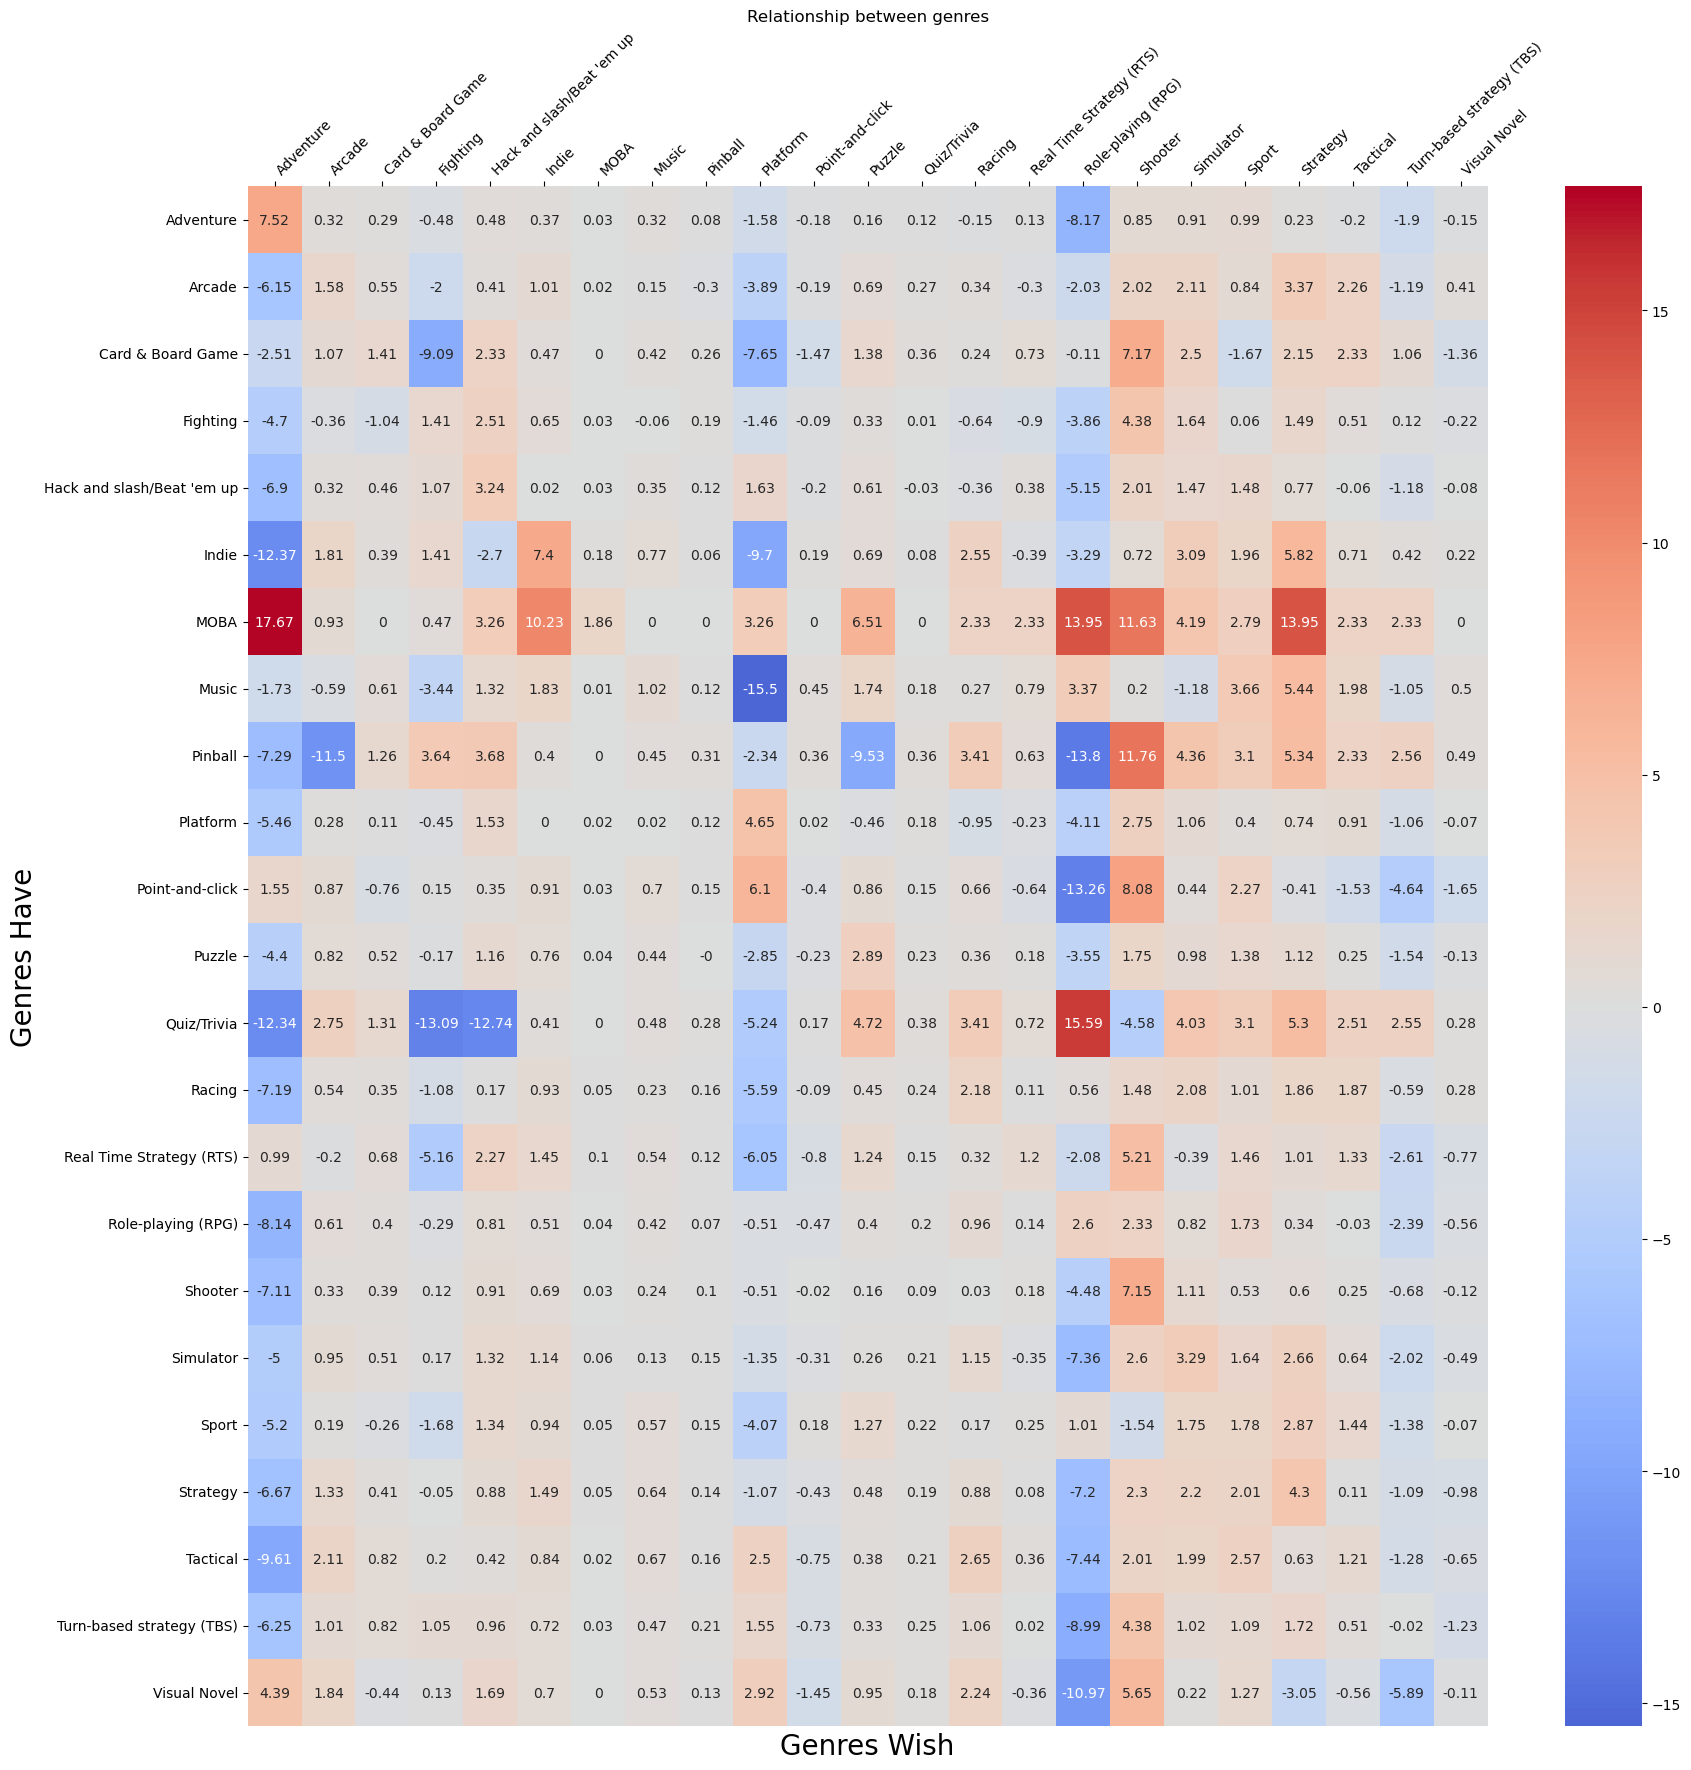

In [14]:
plot_relationship(relationship_diff_plot, 'diff', genres_names=games_genres, processed=True, have_wish=True)